# Projeto | Análise de Texto e Fontes Desestruturadas Web

## Feito por: Beni Kracochansky | Gabriel Kabbani | Rodrigo Mattar

A ideia do projeto é fazer um código que, dado a url do pdf do 10K de uma empresa listada americana, consiga baixar esse pdf e então fazer uma análise gráfica do faturamento e EBITDA da companhia em questão. 

Para testar o funcionamento do projeto, utilizamos o 10K (annual fillings para a SEC) da Apple.


In [1]:
import requests


# PDF para imagem
from pdf2image import convert_from_path

# para trabalhar com diretórios / sistema operacional
import os

# para os DataFrames
import pandas as pd

# para exibir os arquivos de imagem
import cv2
import matplotlib.pyplot as plt

import datetime
import re
import json

#OCR
import pytesseract

### Baixando Arquivo e Salvando como PDF:

In [56]:

data_url = "https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/b4266e40-1de6-4a34-9dfb-8632b8bd57e0.pdf" #link para o 10k da Apple

nome_saida = 'apple10k.pdf'

def baixa(pdf_url, nome_saida):
    response = requests.get(pdf_url) #pegando o pdf
    
    response.raise_for_status()  # vendo se está válido

    with open(nome_saida, 'wb') as output_file:
    
        output_file.write(response.content) #escrevendo arquvio de saida

baixa(data_url, nome_saida)

### Salvando PDF como imagem

In [44]:
paginas = convert_from_path('apple10k.pdf', 200)


In [45]:
#Salvando cada pagina do PDF como imagem para extracao usando OCR
i = 1
lista_imagens = []
for pg in paginas:
    img_path = './img/Apple10k_{}.jpg'.format(i)
    pg.save(img_path, 'JPEG')
    lista_imagens.append(img_path)
    i += 1

### Extraindo os dados das imagens e salvando no arquivo txt


In [46]:
with open('./text/texto.txt', 'w') as f:
    for image_path in lista_imagens:
        try:
            text = pytesseract.image_to_string(image_path)
            str_texto = "".join(text.lower())
            f.write(str_texto)
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")


### Criando Lista de palavras-chave


In [2]:
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

In [3]:
key_words = ["years ended", "net sales", "products", "services", "gross margin", "net income", "operating expenses", "operating income"]

### Verificando existencia de numeros em seuqncia na frase

In [4]:

next_words=[]
word_range=300
with open("./text/texto.txt", "r") as f:
    texto = f.readlines()
    texto = [re.sub(r'[^\w\s]', '', x.strip().lower()) for x in texto if x.strip()!=""]
    for i in range(len(texto)):
        word = texto[i]
        words = word.split(" " or ", ", )
        # words = texto[:i]  if i<word_range else texto[:i-word_range] 
        count = 0
        for j in range(len(words)):
            try:
                int(words[j])
                count = count + 1
            except Exception as e:
                continue
        if(count>2):
            next_words.append(word)
        

           

print(next_words)

    

['indicate by check mark whether the registrant 1 has filed all reports required to be filed by section 13 or 15d of the securities exchange act of 1934 during the preceding 12', '15908 118000 shares of common stock were issued and outstanding as of october 14 2022', 'iphone is the companys line of smartphones based on its ios operating system the iphone line includes iphone 14 pro iphone 14 iphone 13 iphone se', 'members as of september 24 2022 the company had approximately 164000 fulltime equivalent employees', 'as of october 14 2022 there were 23838 shareholders of record', 'june 26 2022 to july 30 2022', 'july 31 2022 to august 27 2022', 'august 28 2022 to september 24 2022', '1 as of september 24 2022 the company was authorized by the board of directors to purchase up to 405 billion of the companys common stock under a', 'share repurchase program most recently announced on april 28 2022 the program of which 3443 billion had been utilized the program does not obligate', '92917 9291

### Criando um simples modelo de Machine Learning para prever quais casos sao realmente dados desejados

In [5]:
%reload_ext autoreload
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from text.labels import labels
from text.train import sentences
print(len(sentences), len(labels))

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

print(classification_report(y_test, predictions))


542 542
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        68
           1       0.92      0.83      0.87        41

    accuracy                           0.91       109
   macro avg       0.91      0.89      0.90       109
weighted avg       0.91      0.91      0.91       109



#### Predizendo sobre o teste inteiro

In [6]:
data = []
with open("./text/texto.txt", "r") as f:
    texto = f.readlines()
    texto = [re.sub(r'[^\w\s]', '', x.strip().lower()) for x in texto if x.strip()!=""]
    for i in range(len(texto)):
        test = classifier.predict(vectorizer.transform([texto[i]]))
        if(test[0]):
            data.append(texto[i])

print(data)

['securities and exchange commission', 'state or other jurisdiction irs employer identification no', 'necessarily a conclusive determination for any other purposes', 'item 5 market for registrants common equity related stockholder matters and issuer purchases of equity securities', 'item 7a quantitative and qualitative disclosures about market risk', 'item 9b other information', 'products', 'mac', 'wearables home and accessories', 'wearables home and accessories includes', ' beats products homepod mini and accessories', 'services', 'cloud services', 'payment services', 'research and development', 'intellectual property', 'values energy shortages and cost increases labor and healthcare costs and other economic factors', 'issues industrial accidents and other business interruptions', 'political events trade and other international disputes war terrorism natural disasters public health issues industrial accidents and other business', 'suppliers contract manufacturers logistics providers d

### Aprimorando os dados para pegar valores que queremos

In [31]:
wn = ["total net sales", "total operating income", "total operating expenses", "operating income"]
uw = ["percentage", "segment", ]
di = []
net_sales = ""
operating_income = ""
operating_expenses = ""
for d in data:
    for w in wn:
        if(w in d):
            if re.search(r'^\D*\d+\s+\d+\s+\d+\D*$', d):
                di.append({w:d.split(w)[1].strip()})
print(di)

[{'total net sales': '6 6 7'}, {'total net sales': '13 12 14'}, {'total net sales': '394328 365817 274515'}, {'total operating expenses': '51345 43887 38668'}, {'operating income': '119437 108949 66288'}, {'operating income': '62683 53382 37722'}, {'operating income': '35233 32505 22170'}, {'operating income': '31153 28504 15261'}, {'operating income': '12257 12798 9279'}, {'operating income': '11569 9817 6808'}, {'operating income': '152895 137006 91240'}, {'total operating income': '119437 108949 66288'}, {'operating income': '119437 108949 66288'}, {'total net sales': '394328  365817  274515'}]


In [32]:
%reload_ext autoreload
for i in di:
    for k, v in i.items():
        for u in uw:
            if(int(v.split(" ")[0]) <= 100):
                try:
                    di.pop(di.index(i))
                except:
                    pass

print(di)

[{'total net sales': '13 12 14'}, {'total net sales': '394328 365817 274515'}, {'total operating expenses': '51345 43887 38668'}, {'operating income': '119437 108949 66288'}, {'operating income': '62683 53382 37722'}, {'operating income': '35233 32505 22170'}, {'operating income': '31153 28504 15261'}, {'operating income': '12257 12798 9279'}, {'operating income': '11569 9817 6808'}, {'operating income': '152895 137006 91240'}, {'total operating income': '119437 108949 66288'}, {'operating income': '119437 108949 66288'}, {'total net sales': '394328  365817  274515'}]


In [33]:
%reload_ext autoreload
for i in di:
    for k, v in i.items():
        if((k == "total net sales") and len(net_sales)==0):
            net_sales = v
        elif (k=="total net sales")  and (int(net_sales[0].split(" ")[0])<100):
            net_sales = v
        if("operating income" in k) and (len(operating_income)==0):
            if ("total operating income" in k):
                operating_income = v
        if(k == "total operating expenses") and (len(operating_expenses)==0):
            operating_expenses = v

In [56]:
%reload_ext autoreload
current_year = datetime.datetime.now().year
years = [str(current_year-1), str(current_year-2), str(current_year-3)]
net_sales_list = net_sales.split(" ")
operating_income_list = operating_income.split(" ")
operating_expenses_list = operating_expenses.split(" ")

net_sales_list = [int(x) for x in net_sales_list if x.isdigit()]
operating_income_list = [int(x) for x in operating_income_list if x.isdigit()]
operating_expenses_list = [int(x) for x in operating_expenses_list if x.isdigit()]

print(net_sales_list)
print(operating_income_list)
print(operating_expenses_list)


[394328, 365817, 274515]
[119437, 108949, 66288]
[51345, 43887, 38668]


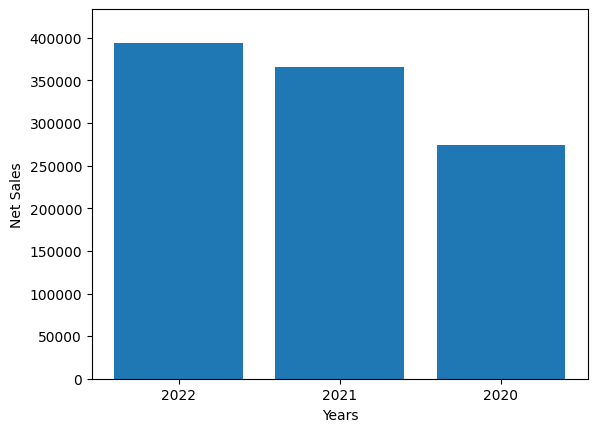

In [57]:
plt.bar(years, net_sales_list)
plt.xlabel("Years")
plt.ylabel("Net Sales")
plt.ylim(0, max(net_sales_list)+(int(max(net_sales_list)*0.1)))
plt.show()